In [1]:
import numpy as np
import pickle as pkl
from pprint import pprint
import os
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd

plt.ion()

In [2]:
dr='/Users/tianyichen/Desktop/Research /PhDresearch/Hopkins_Organoid/April 19 2024/Run_8_TBS_Experiment_ecr_results_windowed/'

In [4]:
dr1=dr+'230601 RUN 8 Wells 1-3'
dr2=dr+'230602 RUN 8 Wells 4-6'

In [5]:
filenames=os.listdir(dr1)
filenames.remove('.DS_Store')
sorted_filenames = sorted(filenames, key=lambda x: int(x.split('#')[1].split()[0]))

In [6]:
sorted_filenames_updated1=['230601 RUN 8 Wells 1-3/'+filename + '/data.raw_20240415_18h04m.pkl' for filename in sorted_filenames]

In [7]:
filenames=os.listdir(dr2)
filenames.remove('.DS_Store')
sorted_filenames = sorted(filenames, key=lambda x: int(x.split('#')[1].split()[0]))
sorted_filenames_updated2=['230602 RUN 8 Wells 4-6/'+filename + '/data.raw_20240415_18h04m.pkl' for filename in sorted_filenames]

In [8]:
sorted_filenames_updated=sorted_filenames_updated1+sorted_filenames_updated2

In [11]:
sorted_filenames_updated

['230601 RUN 8 Wells 1-3/#1 (baseline)/data.raw_20240415_18h04m.pkl',
 '230601 RUN 8 Wells 1-3/#2 (well #1 post stim 1)/data.raw_20240415_18h04m.pkl',
 '230601 RUN 8 Wells 1-3/#3 (well #1 post stim 2)/data.raw_20240415_18h04m.pkl',
 '230601 RUN 8 Wells 1-3/#4 (well #1 post stim 3)/data.raw_20240415_18h04m.pkl',
 '230601 RUN 8 Wells 1-3/#5 (well #1 post stim 4)/data.raw_20240415_18h04m.pkl',
 '230601 RUN 8 Wells 1-3/#6 (well #2 post stim 1)/data.raw_20240415_18h04m.pkl',
 '230601 RUN 8 Wells 1-3/#7 (well #2 post stim 2)/data.raw_20240415_18h04m.pkl',
 '230601 RUN 8 Wells 1-3/#8 (well #2 post stim 3)/data.raw_20240415_18h04m.pkl',
 '230601 RUN 8 Wells 1-3/#9 (well #2 post stim 4)/data.raw_20240415_18h04m.pkl',
 '230601 RUN 8 Wells 1-3/#10 (well #3 post stim 1)/data.raw_20240415_18h04m.pkl',
 '230601 RUN 8 Wells 1-3/#11 (well #3 post stim 2)/data.raw_20240415_18h04m.pkl',
 '230601 RUN 8 Wells 1-3/#12 (well #3 post stim 3)/data.raw_20240415_18h04m.pkl',
 '230601 RUN 8 Wells 1-3/#13 (well #

In [9]:
len(sorted_filenames_updated)

36

In [ ]:
well='well004'

In [10]:
df = pd.read_csv('/Users/tianyichen/Desktop/Research /PhDresearch/Hopkins_Organoid/April 19 2024/Time-file.csv')
df['time'] = pd.to_datetime(df['Unnamed: 1'].astype(str) + ' ' + df['Unnamed: 2'].astype(str), errors='coerce')

for i in df.loc[df['Unnamed: 2'].isnull(),'time'].index:
    df.loc[i,'time'] = df.loc[i-1,'time']+pd.Timedelta(10,'min')

well=4
stimulus_time=df[df[str(well)]==True]['time']
time=df[df['Unnamed: 2'].notna()]['time']
time_diff = [(t - time[0]).total_seconds() / 60 for t in time]
stimulus_time_diff = [(t - time[0]).total_seconds() / 60 for t in stimulus_time]

In [12]:
len(time_diff)

36

In [13]:
data_structure = np.column_stack((sorted_filenames_updated, time_diff))
#print(data_structure)
#float(data_structure[1,1])


In [14]:
all_win=[ 'win_0', 'win_1', 'win_2', 'win_3', 'win_4', 'win_5', 'win_6', 'win_7', 'win_8', 'win_9']


In [15]:
repeated_data = np.repeat(data_structure, 10, axis=0)
final_data = np.vstack((repeated_data[:, 0], repeated_data[:, 1])).T
window = np.array(all_win * len(time_diff)).reshape((-1, 1))
final_data = np.hstack((final_data, window))

In [17]:
for i in range(len(final_data)):
    win = final_data[i][2]
    value = float(final_data[i][1])
    if win == 'win_0':
        final_data[i][1] = str(value + 0)
    elif win == 'win_1':
        final_data[i][1] = str(value + 1)
    elif win == 'win_2':
        final_data[i][1] = str(value + 2)
    elif win == 'win_3':
        final_data[i][1] = str(value + 3)
    elif win == 'win_4':
        final_data[i][1] = str(value + 4)
    elif win == 'win_5':
        final_data[i][1] = str(value + 5)
    elif win == 'win_6':
        final_data[i][1] = str(value + 6)
    elif win == 'win_7':
        final_data[i][1] = str(value + 7)
    elif win == 'win_8':
        final_data[i][1] = str(value + 8)
    elif win == 'win_9':
        final_data[i][1] = str(value + 9)

final_data


array([['230601 RUN 8 Wells 1-3/#1 (baseline)/data.raw_20240415_18h04m.pkl',
        '0.0', 'win_0'],
       ['230601 RUN 8 Wells 1-3/#1 (baseline)/data.raw_20240415_18h04m.pkl',
        '2.0', 'win_1'],
       ['230601 RUN 8 Wells 1-3/#1 (baseline)/data.raw_20240415_18h04m.pkl',
        '4.0', 'win_2'],
       ...,
       ['230602 RUN 8 Wells 4-6/#18 (340 minutes after, Well #5 240 minutes after, Well #6 180 mintes after)/data.raw_20240415_18h04m.pkl',
        '1705.5', 'win_7'],
       ['230602 RUN 8 Wells 4-6/#18 (340 minutes after, Well #5 240 minutes after, Well #6 180 mintes after)/data.raw_20240415_18h04m.pkl',
        '1707.5', 'win_8'],
       ['230602 RUN 8 Wells 4-6/#18 (340 minutes after, Well #5 240 minutes after, Well #6 180 mintes after)/data.raw_20240415_18h04m.pkl',
        '1709.5', 'win_9']], dtype='<U136')

In [18]:
well='well004'

In [20]:
def filter_matrix_TC(data, well, win):

    # Extract necessary data from the loaded data structure
    adj_matrix = data[well][win]['adj_matrix_predicted']
    votes = data[well][win]['votes']  # This variable is loaded but not used in the snippet you provided
    corr_peaks = data[well][win]['corr_peaks']
    fs = data['config']['data']['fs']  # Sampling frequency

    # Initialize a matrix to track synchronization based on correlation peaks
    synced_matrix = np.full(adj_matrix.shape, False)
    for key in corr_peaks.keys():
        if np.all(np.abs(np.array(corr_peaks[key]['delays'])) < 1/fs):
            synced_matrix[key[0], key[1]] = True
            synced_matrix[key[1], key[0]] = True

    # Create the filtered matrix as per the given logic
    filtered_matrix = np.logical_and(adj_matrix, np.logical_not(synced_matrix))

    return filtered_matrix

In [21]:
os.chdir(dr)


In [140]:
all_adj = []
k=-1
kk=[]
number_of_vertices=[] 
for i in range(len(sorted_filenames_updated)):
    with open(sorted_filenames_updated[i], 'rb') as f:
        data = pkl.load(f)
    for j in range(10):
        adj = filter_matrix_TC(data, well, all_win[j])
        k=k+1
        if(sum(sum(adj))>10000):
            kk.append(k)
            all_adj.append(adj)
            number_of_vertices.append(adj.shape[0])
            #print(i,j,k, sum(sum(adj))>10000, adj.shape[0] )


In [141]:
m=len(kk)
m

58

In [142]:
## time points we selected that are dense enough 
tm=final_data[kk,1]

In [143]:
## add zeros to the adj mat such that they have the same dims 
dim = max(number_of_vertices) # Max number of vertices to determine dimension
m=len(all_adj)
adj_aug = np.zeros((m, dim, dim))  # Pre-allocate a zero matrix of the desired size
for i in range(m):
    ma = all_adj[i]  
    l = ma.shape[0]  
    adj_aug[i, :l, :l] = ma 

/Users/tianyichen/opt/anaconda3/lib/python3.9/site-packages/matplotlib/collections.py:196: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


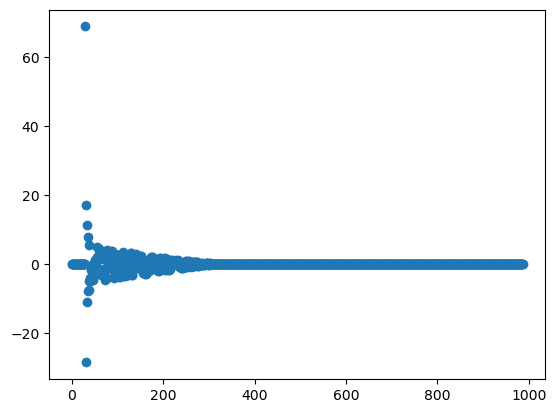

In [144]:
s,u=np.linalg.eig(adj_aug[1])
plt.scatter(range(adj_aug[1].shape[0]),s)

In [80]:
graph_matching=False

from scipy.optimize import quadratic_assignment
from numpy import linalg as LA
adj_gm=np.zeros([m,dim,dim])
adj_gm[0]=adj_aug[0] ## use the first graph as baseline

count = len([x for x in time_diff if x < 400]) ## this records how many times points are on June 01
for i in range(0, count):
    adj_gm[i] = adj_aug[i]
    #print(time_diff[i])

## only match between two days
res = quadratic_assignment(adj_aug[count-1],adj_aug[count],options = {'maximize': True})
perm = res['col_ind']
adj_gm[count] = adj_aug[count][perm][:,perm]

for i in range(count, m):
    adj_gm[i] = adj_aug[i][perm][:,perm]
    #print(time_diff[i])

In [145]:
graph_matching=True

from scipy.optimize import quadratic_assignment
from numpy import linalg as LA
adj_gm=np.zeros([m,dim,dim])
adj_gm[0]=adj_aug[0] ## use the first graph as baseline
for i in range(1, m):
    res = quadratic_assignment(adj_gm[i-1],adj_aug[i],options = {'maximize': True})
    perm = res['col_ind']
    ofv=res['fun']
    fun_I = np.trace(adj_aug[i].T  @ adj_gm[i-1] )
    adj_gm[i]=adj_aug[i][perm][:,perm]
    before_norm = LA.norm(adj_aug[i] - adj_gm[i-1], 'fro')
    after_norm = LA.norm(adj_gm[i] - adj_gm[i-1], 'fro')

     # Printing the before and after norms to see the difference
    print(f"Frob diff before GM: {before_norm}, After GM: {after_norm},OFV before GM: {fun_I}, After GM: {ofv}")

Frob diff before GM: 184.1928337368205, After GM: 132.03408650799233,OFV before GM: 313.0, After GM: 8560.0
Frob diff before GM: 166.87720036002523, After GM: 115.18680479985544,OFV before GM: 406.0, After GM: 7696.0
Frob diff before GM: 188.2763925721969, After GM: 126.26955294131677,OFV before GM: 853.0, After GM: 10605.0
Frob diff before GM: 182.83052261589145, After GM: 126.09123680890754,OFV before GM: 743.0, After GM: 9507.0
Frob diff before GM: 172.98265809034152, After GM: 111.60197130875422,OFV before GM: 296.0, After GM: 9030.0
Frob diff before GM: 196.26003159074443, After GM: 139.76408694654003,OFV before GM: 2184.0, After GM: 11676.0
Frob diff before GM: 219.30344274543435, After GM: 146.83323874382123,OFV before GM: 2962.0, After GM: 16229.0
Frob diff before GM: 196.58331567048106, After GM: 140.77997016621364,OFV before GM: 1850.0, After GM: 11263.0
Frob diff before GM: 188.26576959181932, After GM: 123.10158406779338,OFV before GM: 719.0, After GM: 10864.0
Frob diff bef

In [148]:
## only consider the June 02 data and no matching

choosen_time_points=range(count+20,m)

prod=adj_gm[choosen_time_points[0]]
for i in (range(1,len(choosen_time_points))):
    prod=prod * adj_gm[choosen_time_points[i]]
    print(choosen_time_points[i], sum(sum(prod>0)))

39 18285
40 7894
41 5636
42 5095
43 3286
44 2852
45 1878
46 1301
47 1131
48 825
49 708
50 630
51 379
52 275
53 208
54 181
55 143
56 109
57 95


In [45]:
from graspologic.datasets import load_drosophila_right
from graspologic.plot import heatmap
from graspologic.utils import binarize, symmetrize
import graspologic.utils as graspologic_utils

In [149]:
## find the connected component for the common edge subgraph 
[a,ind]=graspologic_utils.largest_connected_component(prod,return_inds=True)
len(ind)
n=len(ind)
n

51

In [150]:
# double check every adj mat is connected 
glist=np.zeros([len(choosen_time_points),len(ind),len(ind)])
for i in range(len(choosen_time_points)):
    glist[i]=adj_gm[choosen_time_points[i]][ind][:,ind]
    print(graspologic_utils.is_fully_connected(glist[i]))

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


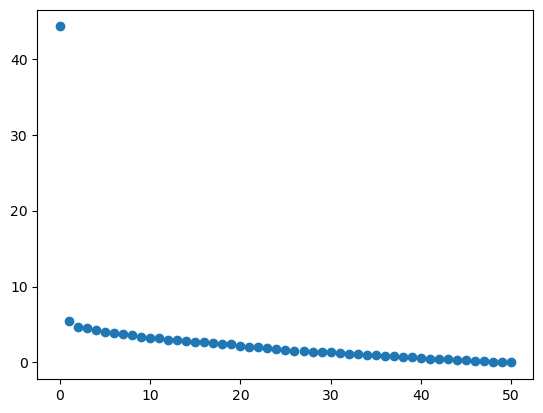

In [151]:
## scree plot for one graph 
u,s,v=np.linalg.svd(glist[0], full_matrices=True)
plt.scatter(range(n),s)

In [51]:
from graspologic.embed import AdjacencySpectralEmbed

In [152]:
tm=choosen_time_points

In [153]:
ed=1
Xhat_list=np.zeros([len(tm),n,2*ed])
for i in range(len(tm)):
    ase = AdjacencySpectralEmbed(n_components=ed)
    Xhat, Yhat = ase.fit_transform(glist[i])
    Xhat_list[i][:,list(np.arange(ed))]=Xhat
    Xhat_list[i][:,list(np.arange(ed,2*ed))]=Yhat

Text(0, 0.5, 'eigen value')

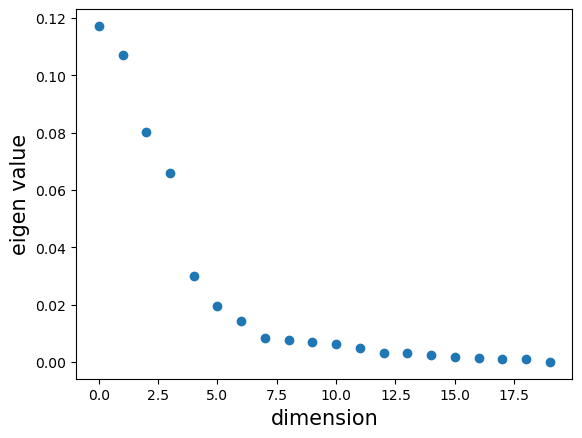

In [154]:
from scipy.linalg import orthogonal_procrustes
D=np.zeros([len(tm),len(tm)])
for i in range(len(tm)):
    for j in range(len(tm)):
        R, sca = orthogonal_procrustes(Xhat_list[i] , Xhat_list[j] )
        D[i,j]=LA.norm(Xhat_list[i] @ R -  Xhat_list[j],2)**2/n  
J=np.ones([len(tm),len(tm)])/len(tm)
I=np.eye(len(tm))
P=I-J
H=(-1/2)*P@D@P
w,v=LA.eig(H)
idx = w.argsort()[::-1]   
w = w[idx]
v = v[:,idx]
plt.scatter(range(len(tm)),w) 
#plt.title('scree plot for MDS')
plt.xlabel('dimension',fontsize=15)
plt.ylabel('eigen value',fontsize=15)

Text(0, 0.5, 'dim 2')

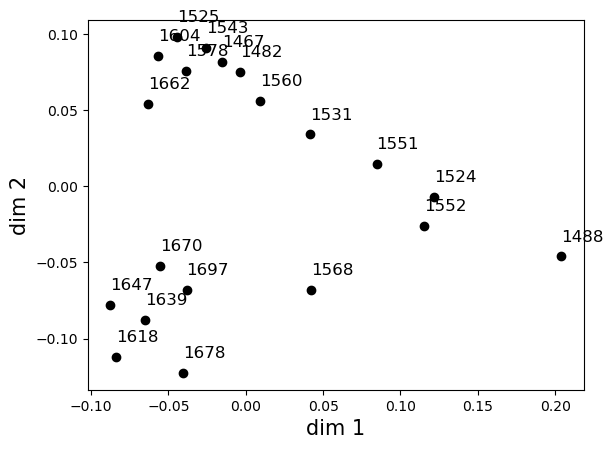

In [155]:
d=4
MDS=v[:,:d] @ np.diag(np.sqrt(w[:d]))
plt.scatter(MDS[:,0],-MDS[:,1],color='black')
for i in range(len(tm)):
    plt.text(MDS[i,0],-MDS[i,1]+0.01,int(float(final_data[kk,1][choosen_time_points[i]])), fontsize=12)
plt.xlabel("dim 1",fontsize=15)
plt.ylabel("dim 2",fontsize=15)

In [156]:
time = [int(float(final_data[kk,1][choosen_time_points[i]])) for i in range(len(choosen_time_points))]

In [117]:
from sklearn.manifold import Isomap

In [158]:
embedding = Isomap(n_neighbors=3,n_components=1)
iso = embedding.fit_transform(MDS)

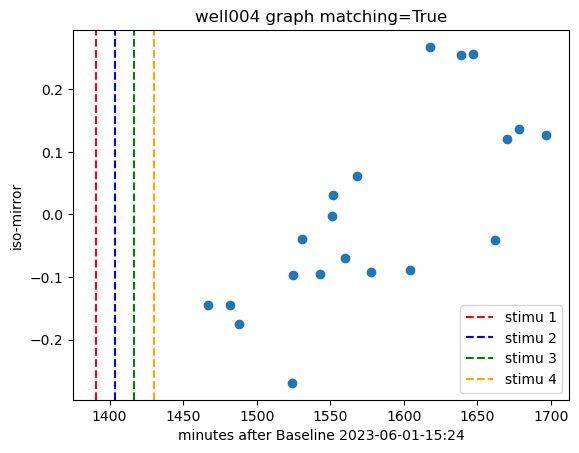

In [159]:

# Plot the scatter plot
plt.scatter(time,-iso)

# Add vertical lines
plt.axvline(x=stimulus_time_diff[0], color='red', linestyle='--', label='stimu 1')
plt.axvline(x=stimulus_time_diff[1], color='blue', linestyle='--', label='stimu 2')
plt.axvline(x=stimulus_time_diff[2], color='green', linestyle='--', label='stimu 3')
plt.axvline(x=stimulus_time_diff[3], color='orange', linestyle='--', label='stimu 4')

# Set the x-axis label and y-axis label
plt.xlabel('minutes after Baseline 2023-06-01-15:24')
plt.ylabel('iso-mirror')

# Add a title
plt.title(str(well)+' graph matching='+str(graph_matching))

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [160]:
time

[1467,
 1482,
 1488,
 1524,
 1525,
 1531,
 1543,
 1551,
 1552,
 1560,
 1568,
 1578,
 1604,
 1618,
 1639,
 1647,
 1662,
 1670,
 1678,
 1697]

In [73]:
stimulus_time_diff
time

[1467, 1482, 1525, 1543, 1560, 1578, 1604, 1662]

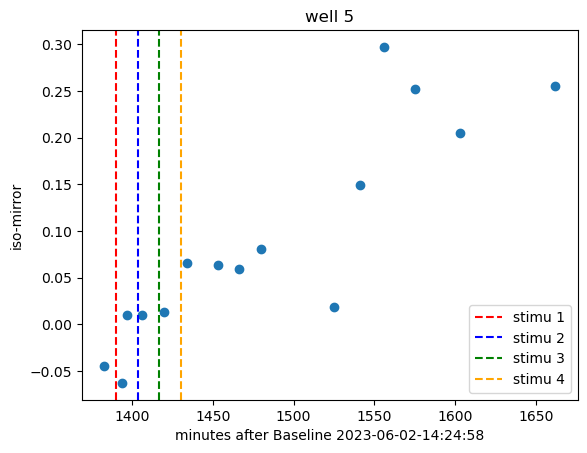

In [199]:
# Plot the scatter plot
plt.scatter(new_list[11:], iso[11:])

# Add vertical lines
plt.axvline(x=stimulus_time_diff[0], color='red', linestyle='--', label='stimu 1')
plt.axvline(x=stimulus_time_diff[1], color='blue', linestyle='--', label='stimu 2')
plt.axvline(x=stimulus_time_diff[2], color='green', linestyle='--', label='stimu 3')
plt.axvline(x=stimulus_time_diff[3], color='orange', linestyle='--', label='stimu 4')

# Set the x-axis label and y-axis label
plt.xlabel('minutes after Baseline 2023-06-02-14:24:58')
plt.ylabel('iso-mirror')

# Add a title
plt.title('well 5')

# Add a legend
plt.legend()

# Show the plot
plt.show()
